In [34]:
import os, json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import _stop_words
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

In [53]:
INPUT_FILES = {
'Hermione': 'data/hermione_granger_classified.csv',
'Ron': 'data/ron_weasley_classified.csv',
'Dumbledore': 'data/albus_dumbledore_classified.csv'
}

In [54]:
dfs = {}
for char, fn in INPUT_FILES.items():
    dfs[char] = pd.read_csv(fn)
    dfs[char]["Character Name"] = char
    # ensure strings
    dfs[char]["Dialogue"] = dfs[char]["Dialogue"].astype(str)
    dfs[char]["Topic"] = dfs[char]["Topic"].astype(str)

rename_dict = {
    "magical theory & practice": "magic",
    "dark arts & danger": "threats"
}

for df in dfs.values():
    df["Topic"] = df["Topic"].replace(rename_dict)

combined_df = pd.concat(list(dfs.values()), ignore_index=True)

In [55]:
print("Loaded character lines:")
for c, df in dfs.items():
    print(f"  {c}: {len(df)} lines, {df['Topic'].nunique()} topics")
print("Total:", len(combined_df))

Loaded character lines:
  Hermione: 300 lines, 7 topics
  Ron: 300 lines, 7 topics
  Dumbledore: 300 lines, 7 topics
Total: 900


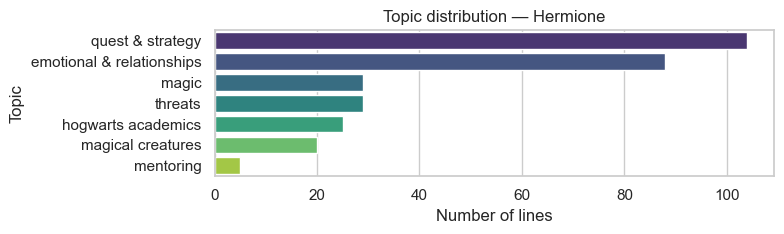

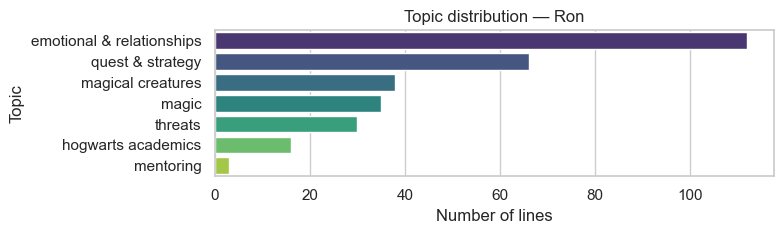

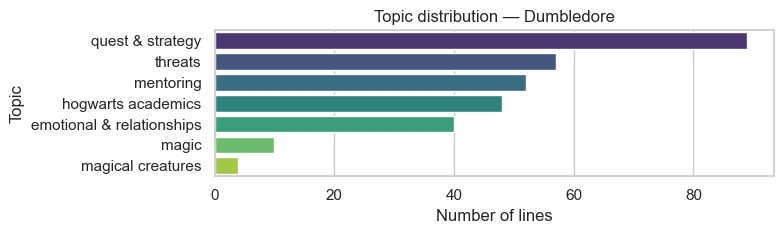

In [56]:
def plot_topic_distribution(df, character, figsize=(8,6)):
    counts = df[df["Character Name"] == character]["Topic"].value_counts()
    plt.figure(figsize=figsize)
    sns.barplot(
        x=counts.values,
        y=counts.index,
        hue=counts.index,     # assign y to hue as recommended
        dodge=False,
        palette="viridis",
        legend=False
    )
    plt.title(f"Topic distribution — {character}")
    plt.xlabel("Number of lines")
    plt.ylabel("Topic")
    plt.tight_layout()
    plt.show()

for c in dfs.keys():
    plot_topic_distribution(
        combined_df,
        c,
        figsize=(8, max(2.5, dfs[c]['Topic'].nunique() * 0.35))
    )

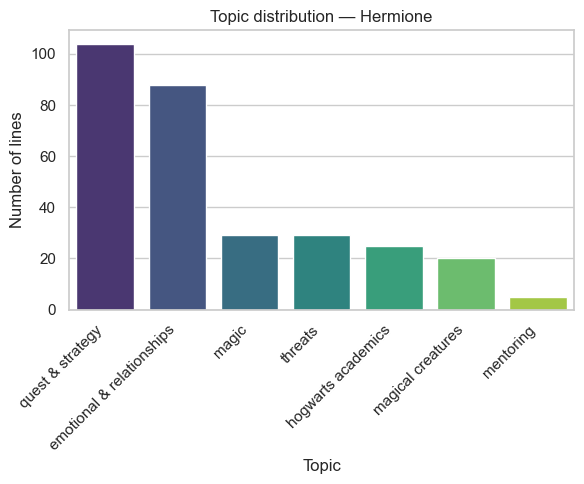

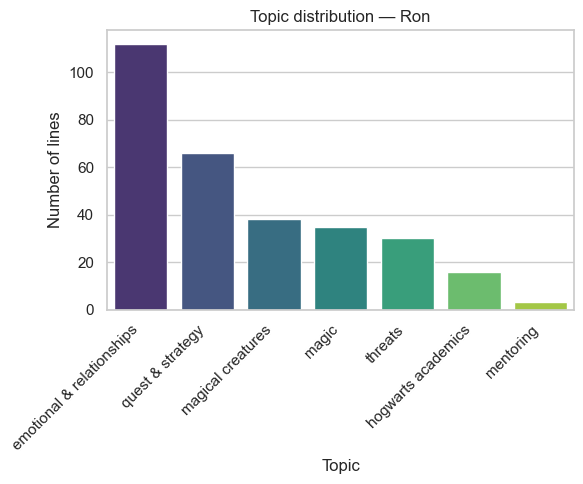

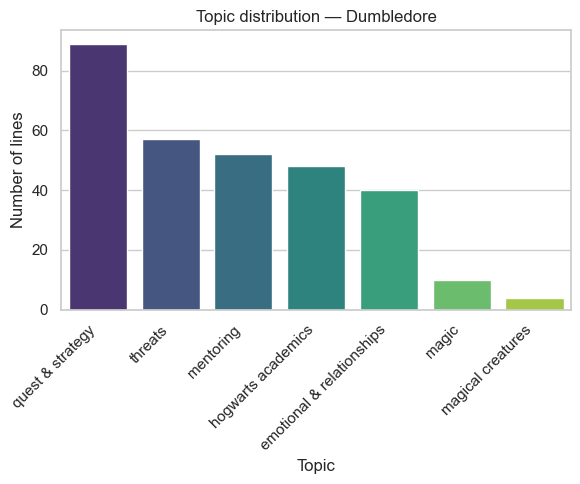

In [57]:
def plot_topic_distribution(df, character, figsize=(8,6)):
    counts = df[df["Character Name"] == character]["Topic"].value_counts()
    plt.figure(figsize=figsize)
    sns.barplot(
        x=counts.index,   # topics on x-axis
        y=counts.values,  # counts on y-axis
        palette="viridis"
    )
    plt.title(f"Topic distribution — {character}")
    plt.xlabel("Topic")
    plt.ylabel("Number of lines")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

for c in dfs.keys():
    plot_topic_distribution(
        combined_df,
        c,
        figsize=(max(6, dfs[c]['Topic'].nunique()*0.8), 5)
    )


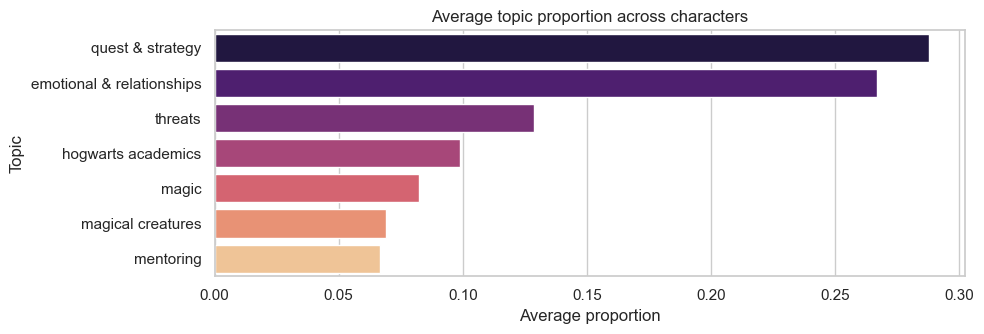

In [58]:
chars = sorted(combined_df['Character Name'].unique())
topic_props = {}

for char in chars:
    vc = combined_df[combined_df["Character Name"]==char]["Topic"].value_counts(normalize=True)
    topic_props[char] = vc

prop_df = pd.DataFrame(topic_props).fillna(0)
avg_prop = prop_df.mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, max(3.5, len(avg_prop)*0.4)))
sns.barplot(x=avg_prop.values, y=avg_prop.index, palette="magma")
plt.xlabel("Average proportion")
plt.ylabel("Topic")
plt.title("Average topic proportion across characters")
plt.tight_layout()
plt.show()

In [59]:
topic_docs = combined_df.groupby("Topic")["Dialogue"].apply(lambda s: " ".join(s)).to_dict()
topics = sorted(topic_docs.keys())
corpus = [topic_docs[t] for t in topics]

custom_stopwords = ["i'm", "know", "did", "it's", "don't", "he's", "think", "got", "that's", "come", "you're", "exactly", "certain", "yes", "different", "wait", "we've got", "they're", "like", "bit", "can't", "she's", "right", "we've", "isn't", "okay", "man"]

# Combine with built-in English stopwords
all_stopwords = list(_stop_words.ENGLISH_STOP_WORDS.union(custom_stopwords))

vectorizer = TfidfVectorizer(
    stop_words=all_stopwords,
    ngram_range=(1,2),
    min_df=1,
    max_features=30000,
    token_pattern=r"[a-zA-Z0-9']+"   # keeps contractions together
)

X = vectorizer.fit_transform(corpus)
feature_names = np.array(vectorizer.get_feature_names_out())

topic_top_terms = {}
TOP_K = 10

for i, t in enumerate(topics):
    row = X[i].toarray().ravel()
    top_idx = row.argsort()[::-1][:TOP_K]
    terms_scores = [(feature_names[j], float(row[j])) for j in top_idx]
    topic_top_terms[t] = terms_scores

In [60]:
for topic, terms in topic_top_terms.items():
    print(f"\n=== {topic} — Top {TOP_K} TF-IDF terms ===")
    for w, score in terms:
        print(f"{w:25s} {score:.4f}")


=== emotional & relationships — Top 10 TF-IDF terms ===
harry                     0.3505
ron                       0.1157
just                      0.1078
ginny                     0.1068
hermione                  0.1057
funny                     0.0858
great                     0.0793
brilliant                 0.0761
really                    0.0713
worried                   0.0712

=== hogwarts academics — Top 10 TF-IDF terms ===
professor                 0.2585
points                    0.2209
post                      0.1325
tri wizard                0.1104
tournament                0.1104
house                     0.1100
hogwarts                  0.1049
school                    0.0953
gryffindor                0.0940
students                  0.0917

=== magic — Top 10 TF-IDF terms ===
potion                    0.1294
alohomora                 0.1169
wand                      0.1143
harry                     0.1143
spell                     0.0971
work                      0.083

In [61]:
topic_lines = combined_df.groupby("Topic")["Dialogue"].apply(list).to_dict()

for topic, lines in topic_lines.items():
    print("\n" + "="*80)
    print(f"TOPIC: {topic}  ({len(lines)} lines)")
    print("="*80)

    joined_text = "\n".join(lines)
    print(joined_text[:5000])   # print first chunk so notebook isn't flooded

    if len(joined_text) > 5000:
        print("\n[... truncated for notebook display ...]\n")


TOPIC: emotional & relationships  (240 lines)
No one was screaming, Harry.
How are you feeling?
What's wrong, Harry?
Are you okay?
That's great.
That felt good.
Harry, no way! ... You don't even know how to fly. What an idiot.
That looks really painful.
McGonagall is worried. All the teachers are.
Good morning, Mr. Weasley.
Ow! You stood on my foot!
I can't believe it—she's done it again...
Come on! Everyone's been worried.
Oh, no. Okay, relax.
Get off me!
I don't like this. Not at all.
Are you all right?
She's a little sensitive.
Oh I'm sorry.
That's what you think?
If you're talking about Malfoy.
Sorry I'll just go.
I won't be going alone—someone asked me.
We know the truth. Please believe us.
I don't like flying!
Are you alright? You must be freezing!
You foul loathsome evil little cockroach!
Don't forget to give Professor Longbottom our best.
Just forget it.
Just ignore him.
Uh... we were just...
Thanks, Sir Nicholas!
This is horrible.
You won't make a fool of yourself. It's in yo

In [62]:
import os

# Make a folder to store topic files
os.makedirs("topic_texts", exist_ok=True)

for topic, lines in topic_lines.items():
    # Clean the topic name for file usage
    safe_topic_name = topic.replace(" ", "_").replace("/", "_")
    filename = os.path.join("topic_texts", f"{safe_topic_name}.txt")

    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print(f"Wrote {len(lines)} lines to {filename}")

Wrote 240 lines to topic_texts/emotional_&_relationships.txt
Wrote 89 lines to topic_texts/hogwarts_academics.txt
Wrote 74 lines to topic_texts/magic.txt
Wrote 62 lines to topic_texts/magical_creatures.txt
Wrote 60 lines to topic_texts/mentoring.txt
Wrote 259 lines to topic_texts/quest_&_strategy.txt
Wrote 116 lines to topic_texts/threats.txt
